In [1]:
#https://www.kaggle.com/rajmehra03/a-comprehensive-guide-to-transfer-learning/data
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

In [2]:
import os
print(os.listdir('/content/drive/MyDrive/AI/TransferLearning/flowers'))

['rose', 'dandelion', 'tulip', 'daisy', 'sunflower']


In [3]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/AI/TransferLearning/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/AI/TransferLearning/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/AI/TransferLearning/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/AI/TransferLearning/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/AI/TransferLearning/flowers/rose'


In [4]:
weights_path='/content/drive/MyDrive/AI/TransferLearning/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [03:36<00:00,  3.52it/s]

764


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [03:43<00:00,  3.27it/s]

1497


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [04:41<00:00,  3.49it/s]

2481


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [04:49<00:00,  3.63it/s]

3533


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [03:44<00:00,  3.49it/s]

4317


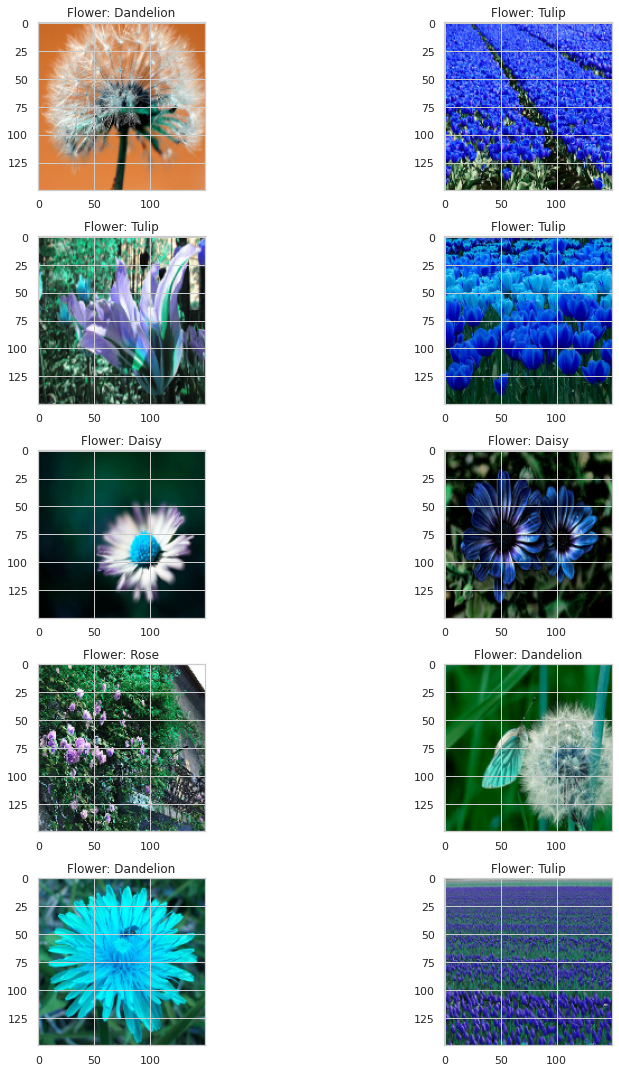

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [13]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [15]:
np.random.seed(42)
rn.seed(42)

In [16]:
base_model=VGG16(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')

In [17]:
base_model.load_weights(weights_path)

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [19]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [21]:
epochs=20
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


In [23]:
base_model.trainable=False # setting the VGG model to be untrainable.

In [24]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 20, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/20
25/25 [==============================] - 41s 1s/step - loss: 1.6270 - accuracy: 0.2557 - val_loss: 1.5512 - val_accuracy: 0.3537
Epoch 2/20
25/25 [==============================] - 21s 817ms/step - loss: 1.4832 - accuracy: 0.4178 - val_loss: 1.4516 - val_accuracy: 0.4380
Epoch 3/20
25/25 [==============================] - 20s 816ms/step - loss: 1.3862 - accuracy: 0.5185 - val_loss: 1.3506 - val_accuracy: 0.5806
Epoch 4/20
25/25 [==============================] - 20s 814ms/step - loss: 1.2980 - accuracy: 0.5790 - val_loss: 1.2580 - val_accuracy: 0.6259
Epoch 5/20
25/25 [==============================] - 21s 817ms/step - loss: 1.2122 - accuracy: 0.6118 - val_loss: 1.1769 - val_accuracy: 0.6519
Epoch 6/20
25/25 [==============================] - 21s 845ms/step - loss: 1.1375 - accuracy: 0.6375 - val_loss: 1.0997 - val_accuracy: 0.6648
Epoch 7/20
25/25 [==============================] - 21s 818ms/step - loss: 1.0693 - accuracy: 0.6529 - val_loss: 1.0401 - val_accuracy: 0.6796
Ep

In [26]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False

0 <keras.engine.input_layer.InputLayer object at 0x7f8a6c03e190>
1 <keras.layers.convolutional.Conv2D object at 0x7f8a5ebdead0>
2 <keras.layers.convolutional.Conv2D object at 0x7f8a5f094d50>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f8a5ebffa50>
4 <keras.layers.convolutional.Conv2D object at 0x7f8a507ea910>
5 <keras.layers.convolutional.Conv2D object at 0x7f8a507f1090>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f8a507f7190>
7 <keras.layers.convolutional.Conv2D object at 0x7f8a507f4650>
8 <keras.layers.convolutional.Conv2D object at 0x7f8a507fb890>
9 <keras.layers.convolutional.Conv2D object at 0x7f8a50803c50>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f8a50807910>
11 <keras.layers.convolutional.Conv2D object at 0x7f8a507ee950>
12 <keras.layers.convolutional.Conv2D object at 0x7f8a50790510>
13 <keras.layers.convolutional.Conv2D object at 0x7f8a50798750>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f8a5080c090>
15 <keras.layers.convolutional.Conv2D object at 

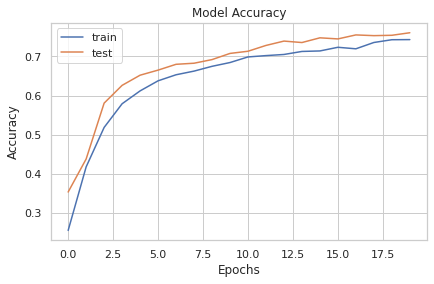

In [27]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

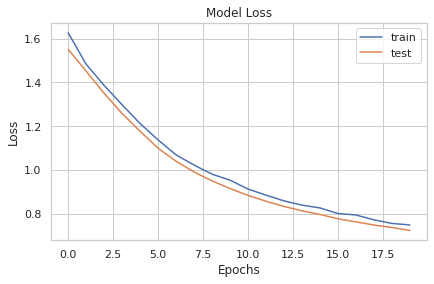

In [28]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [29]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [33]:
print(pred_digits)

[4 4 4 ... 3 3 2]


In [34]:
pred_digits[prop_class[count]]

4

In [30]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

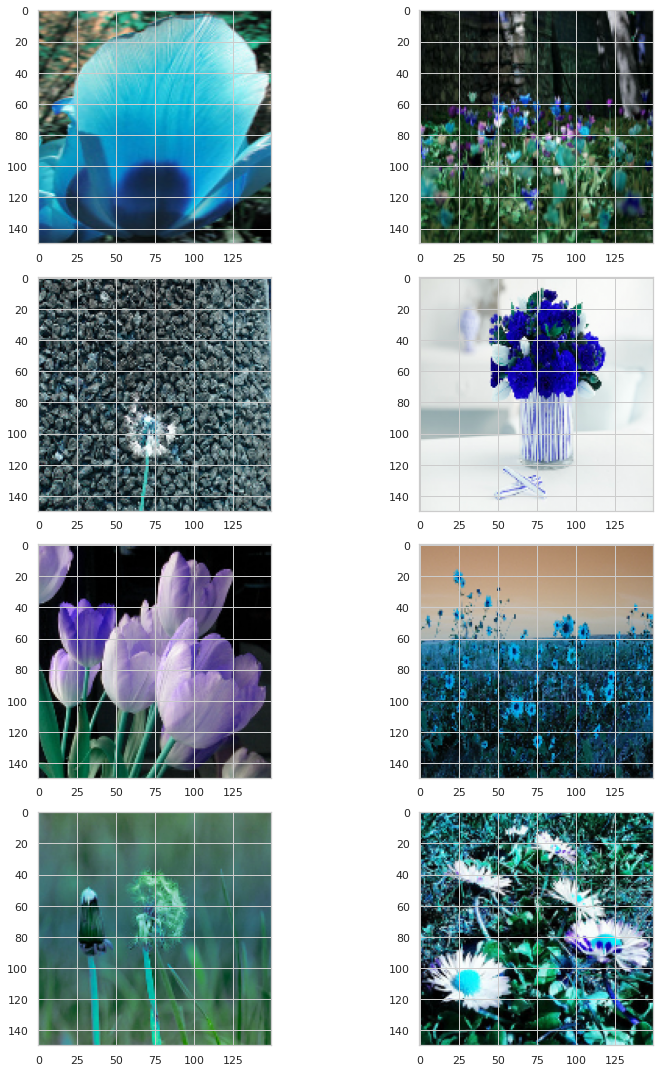

In [35]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        plt.tight_layout()
        count+=1

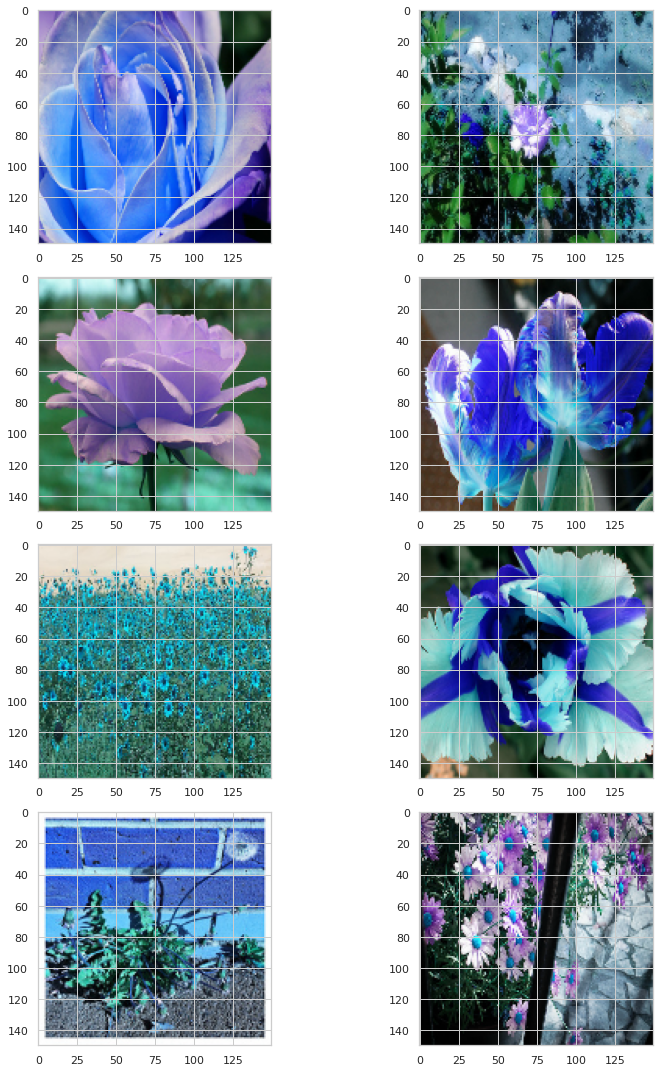

In [36]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        plt.tight_layout()
        count+=1